In [109]:
import os
import json

import matplotlib.pyplot as plt
import numpy as np
import albumentations as A

import torch
from torch.utils.data import DataLoader

from Trainer import Trainer
from build import Model, Criterion, Optimizer, Scheduler, Transform
from utils import fix_random_seed

import neptune.new as neptune
import neptune_config

In [73]:
import os

import cv2
import numpy as np
import albumentations as A
from albumentations.pytorch import ToTensorV2

from torch.utils.data import Dataset
from pycocotools.coco import COCO


transform2tensor = ToTensorV2()

category_names = [
    "Background",
    "UNKNOWN",
    "General trash",
    "Paper",
    "Paper pack",
    "Metal",
    "Glass",
    "Plastic",
    "Styrofoam",
    "Plastic bag",
    "Battery",
    "Clothing",
]


class CocoDataset(Dataset):
    def __init__(self, json_path, data_path, input_size=(512, 512), norm_mean=(0, 0, 0), norm_std=(1, 1, 1), mode="train", transform=None):
        super().__init__()
        self.input_size = input_size
        self.normalizer = A.Compose([A.Normalize(mean=norm_mean, std=norm_std, always_apply=True)])
        self.resizer = A.Compose([A.Resize(*input_size, interpolation=cv2.INTER_AREA, always_apply=True)])
        self.mode = mode
        self.transform = transform

        self.coco = COCO(json_path)
        self.data_path = data_path

    def __getitem__(self, idx):
        if hasattr(idx, "__iter__") or isinstance(idx, slice):
            if isinstance(idx, slice):
                idx = range(*idx.indices(len(self)))

            if self.mode in ["train", "valid"]:
                images, masks, image_infos = [], [], []
                for i in idx:
                    image, mask, image_info = self.__getitem__(i)
                    images.append(image)
                    masks.append(mask)
                    image_infos.append(image_info)
                
                return images, masks, image_infos
                
            if self.mode == "test":
                images, image_infos = [], []
                for i in idx:
                    image, image_info = self.__getitem__(i)
                    images.append(image)
                    image_infos.append(image_info)
                
                return images, image_infos
            

        image_id = self.coco.getImgIds(imgIds=idx)
        image_infos = self.coco.loadImgs(image_id)[0]

        image = cv2.imread(os.path.join(self.data_path, image_infos["file_name"]))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        if self.mode in ["train", "valid"]:
            ann_ids = self.coco.getAnnIds(imgIds=image_infos["id"])
            anns = self.coco.loadAnns(ann_ids)

            cat_ids = self.coco.getCatIds()
            cats = self.coco.loadCats(cat_ids)

            mask = np.zeros((image_infos["height"], image_infos["width"]))
            for ann in anns:
                class_name = get_classname(ann["category_id"], cats)
                pixel_value = category_names.index(class_name)
                mask = np.maximum(self.coco.annToMask(ann) * pixel_value, mask)

            if self.transform is not None:
                transformed = self.transform(image=image, mask=mask)
                image = transformed["image"]
                mask = transformed["mask"]

            # Resize to input size.
            if (*image.shape[:2],) != (*self.input_size,):
                transformed = self.resizer(image=image, mask=mask)
                image = transformed["image"]
                mask = transformed["mask"]

            # Normalize image.
            transformed = self.normalizer(image=image, mask=mask)
            image = transformed["image"]
            mask = transformed["mask"]

            image = image.astype(np.float32)
            mask = mask.astype(np.long)

            # Convert to tensor.
            transformed = transform2tensor(image=image, mask=mask)
            image = transformed["image"]
            mask = transformed["mask"]

            return image, mask, image_infos

        if self.mode == "test":
            if self.transform is not None:
                transformed = self.transform(image=image)
                image = transformed["image"]

            # Resize to input size.
            if (*image.shape[:2],) != (*self.input_size,):
                transformed = self.resizer(image=image)
                image = transformed["image"]

            # Normalize image.
            transformed = self.normalizer(image=image)
            image = transformed["image"]

            # Convert to tensor.
            transformed = transform2tensor(image=image)
            image = transformed["image"]

            return image, image_infos

        raise Exception("Mode argument must be one of [train, valid, test].")

    def __len__(self):
        return len(self.coco.getImgIds())


def get_classname(classID, cats):
    for cat in cats:
        if cat["id"] == classID:
            return cat["name"]
    return "None"

In [43]:
CONFIGS = {
    # Model configs.
    "MODEL_NAME": "HRNet",
    "MODEL_PARAMS": {
        "cfg_path": "code/builder/seg_hrnet_w48_520x520_ohem_sgd_lr1e-3_wd1e-4_bs_16_epoch110.yaml",
        "pth_path": "code/builder/seg_hrnet_w48_520x520_ohem_sgd_lr1e-3_wd1e-4_bs_16_epoch110.pth",
        "classes": 12
    },
    # Criterion configs.
    "CRITERION_NAME": "CrossEntropyLoss",
    "CRITERION_PARAMS": {},
    # Optimizer configs.
    "OPTIMIZER_NAME": "AdamP",
    "OPTIMIZER_PARAMS": {},
    # Scheduler configs.
    "SCHEDULER_NAME": "MultiStepLR",
    "SCHEDULER_PARAMS": {"milestones": [5, 10, 15, 20, 25], "gamma": 0.4},
    "SCHEDULER_STEP_TYPE": "epoch",
    # Data configs.
    "INPUT_SIZE": (256, 256),
    "NORM_MEAN": [0.485, 0.456, 0.406],
    "NORM_STD": [0.229, 0.224, 0.225],
    "AUGMENTATION": [
    ],
    # Training configs.
    "EPOCH_NUM": 30,
    "BATCH_SIZE": 32,
    "LEARNING_RATE": 1e-4,
    "K-FOLD_NUM": 0,
    "EARLY_STOP_NUM": 5,
    "EARLY_STOP_TARGET": "mIoU",
}

In [74]:
transform = Transform(CONFIGS["AUGMENTATION"])

data_path = "../input/data"
train_json = os.path.join(data_path, "train.json")
valid_json = os.path.join(data_path, "valid.json")
# dataset.
train_dataset = CocoDataset(
    json_path=train_json,
    data_path=data_path,
    input_size=CONFIGS["INPUT_SIZE"],
    norm_mean=CONFIGS["NORM_MEAN"],
    norm_std=CONFIGS["NORM_STD"],
    mode="train",
    transform=transform,
)
valid_dataset = CocoDataset(
    json_path=valid_json,
    data_path=data_path,
    input_size=CONFIGS["INPUT_SIZE"],
    norm_mean=CONFIGS["NORM_MEAN"],
    norm_std=CONFIGS["NORM_STD"],
    mode="valid",
    transform=transform,
)

loading annotations into memory...
Done (t=5.04s)
creating index...
index created!
loading annotations into memory...
Done (t=0.95s)
creating index...
index created!


In [75]:
def collate_fn(batch):
    return tuple(zip(*batch))

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4, collate_fn=collate_fn)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=True, num_workers=4, collate_fn=collate_fn)

In [108]:
idxs = np.random.choice(len(train_loader.dataset), 3)
train_loader.dataset[idxs][1][0].shape

torch.Size([256, 256])

In [107]:
train_dataset.normalizer.transforms.transforms[0].mean

[0.485, 0.456, 0.406]

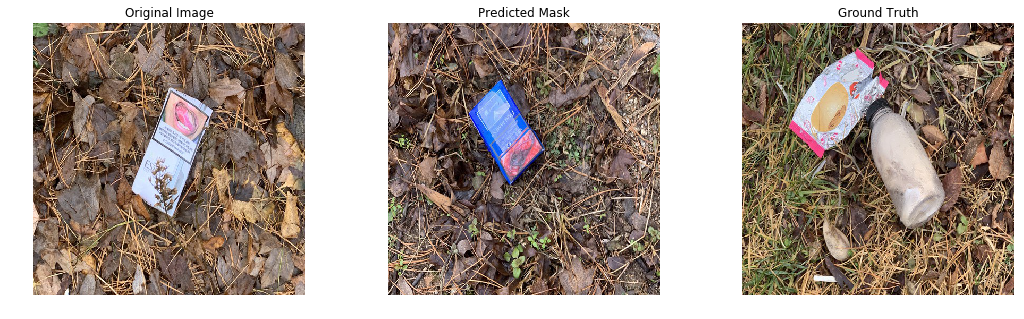

In [114]:
plt.figure(figsize=(18, 5))

test_1 = plt.imread("../input/data/batch_03/0001.jpg")
test_2 = plt.imread("../input/data/batch_03/0002.jpg")
test_3 = plt.imread("../input/data/batch_03/0003.jpg")

plt.subplot(1, 3, 1)
plt.axis("off")
plt.title("Original Image")
plt.imshow(test_1)

plt.subplot(1, 3, 2)
plt.axis("off")
plt.title("Predicted Mask")
plt.imshow(test_2)

plt.subplot(1, 3, 3)
plt.axis("off")
plt.title("Ground Truth")
plt.imshow(test_3)

plt.savefig("./test_image.jpg")

In [1]:
import segmentation_models_pytorch as smp

In [3]:
diceloss = smp.losses.DiceLoss